# Week2

## Plotting correlation between bigWigs
I used **spearman correlation** to calculate the correlation between the bigWig files, as the data is not necessarily normally distributed.

## Generating a set of reproducible peaks with bedtools intersect
I defined reproducible peaks as those that exhibited at least a 50% reciproposal overlap between the two replicated, rep1 and rep2.

## Filtering peaks found in ENCODE blacklist regions
I removed peaks that overlapped a blacklisted region by at least 1bp.

# Week3

## Generating a signal intensity plot for all human genes using computeMatrix and plotProfile for IP samples
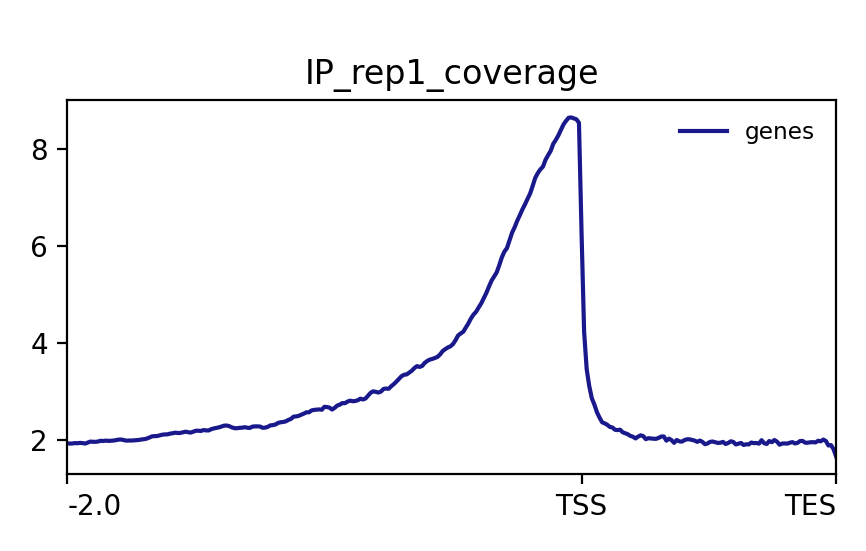　
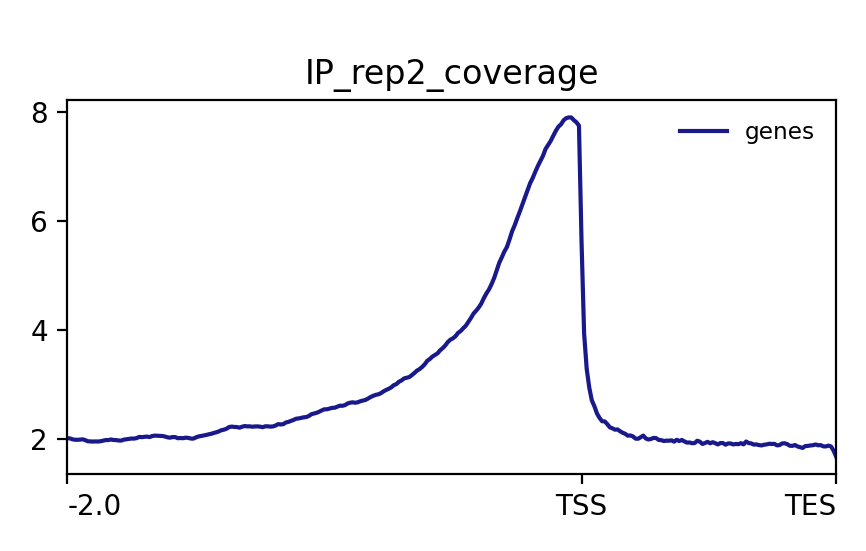  
  
These figures display the average ChIP-seq signal coverage for two replicates (IP_rep1 and IP_rep2) aligned relative to gene bodies. The profiles were generated using the computeMatrix and plotProfile modules from the deepTools. ChIP-seq reads were aligned to the reference genome, and peaks were called using MACS3. To ensure reproducibility and accuracy, we used peak sets from both replicates and retained only those that overlapped by at least 50% in both directions. This filtered set of consistent peaks was further refined by removing regions flagged in the ENCODE blacklist. The resulting BigWig coverage files were summarized across the gene body (from 2 kb upstream of the transcription start site to the transcription end site) using the filtered peak regions. Both replicates exhibit a sharp enrichment near the TSS, indicating specific binding activity and strong consistency across replicates.


## Finding enriched motifs in ChIP-seq peaks
**Top ten enriched motifs:**  
  
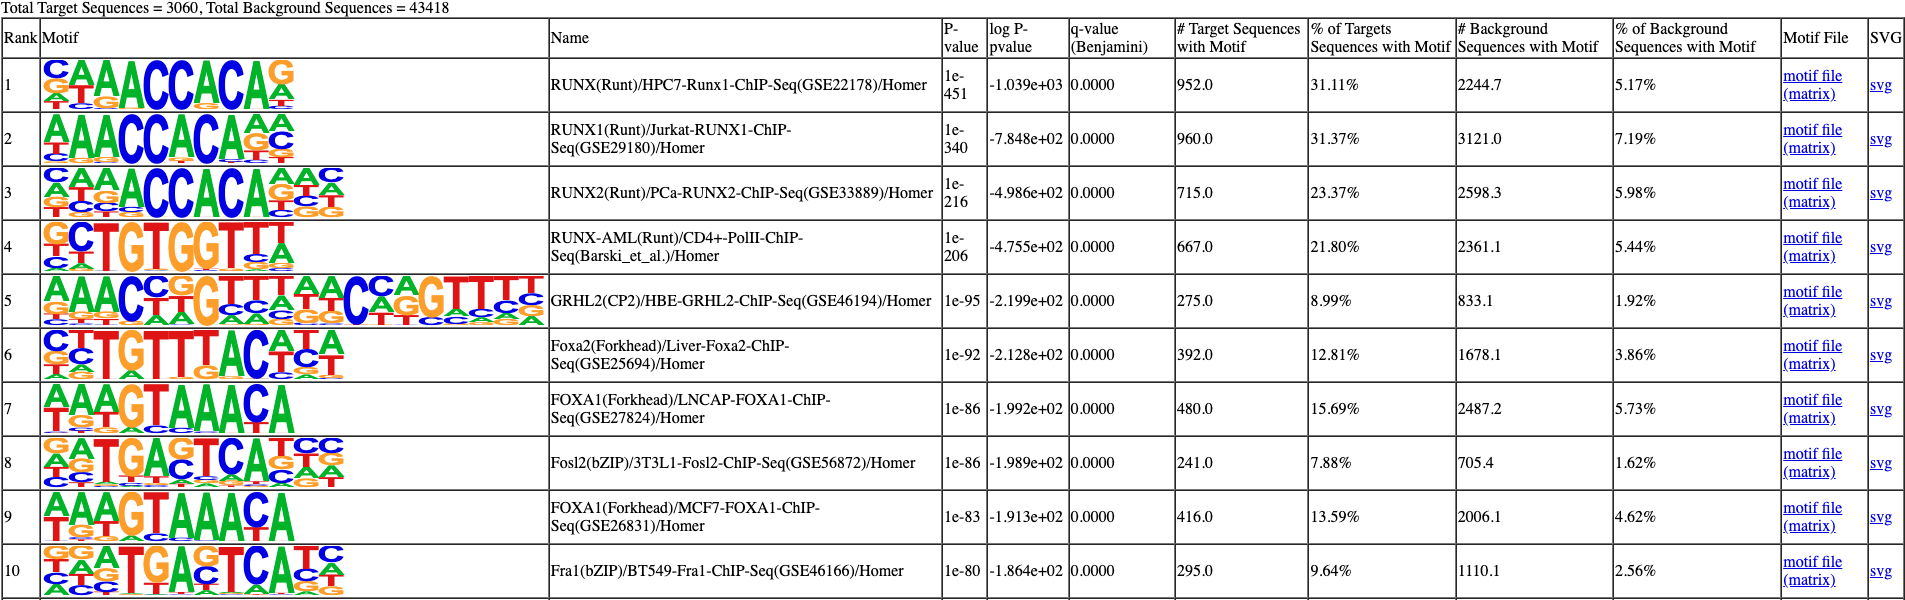  
  
The motif analysis identified several highly enriched transcription factor binding motifs within the filtered ChIP-seq peaks. The top motifs were predominantly associated with the RUNX family (RUNX1 and RUNX2), which ranked 1st through 4th with exceptionally low p-values and were present in over 20–30% of the target sequences. Other notable enriched motifs included GRHL2, FoxA1/2, FosL2, and Fra1, which are associated with transcriptional regulation in development and differentiation. The strong enrichment of RUNX motifs suggests that RUNX transcription factors may play a major regulatory role in the genomic regions identified by ChIP-seq, potentially acting as primary drivers of the observed binding patterns.

# Week4

## Methods section

Raw ChIP=seq reads were subjected to quality control using FastQC v0.12.1, followed by adapter trimming with Trimmomatic v0.39 in single-end mode with the following parameters: ILLUMINACLIP:TruSeq3-SE:2:30:10 LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36. The -phred33 encoding was specified, and adapter trimming logs were saved with the -trimlog option. Quality metrics before and after trimming were aggregated using MultiQC v1.25 to ensure read quality prior to alignment.  

Trimmed reads were aligned to the reference genome using Bowtie2 v2.5.4 in single-end mode with the following parameters: --very-fast, and resulting alignment files were sorted and indexed using samtools v1.21. Alignment quality was further assessed using samtools flagstat, providing metrics such as total mapped reads and mapping rates.  

To generate normalized signal tracks, BAM files were processed with deepTools v3.5.5 bamCoverage with default parameters, which produced bigWig coverage files for each replicate. These were subsequently summarized using multiBigwigSummary in bins mode, and sample correlations were visualized as a heatmap with plotCorrelation using spearman correlation to assess consistency across replicates.  

Peak calling was performed using MACS3 v3.0.3 for each IP sample. To obtain a high-confidence peak set, we compared peak lists across biological replicates and retained only those with at least 50% reciprocal overlap using bedtools intersect. Regions overlapping ENCODE blacklist regions were excluded to eliminate known artifacts, resulting in a refined set of reproducible peaks.  

For functional annotation, filtered peaks were annotated with respect to genomic features using HOMER v4.11.1 annotatePeaks.pl. Enriched DNA-binding motifs were identified using HOMER findMotifsGenome.pl, and both known and de novo motif enrichment results were reviewed to infer potential regulatory factors associated with the peaks.  

Finally, to visualize global signal distribution across gene structures, we performed metagene analysis. Normalized bigWig files were processed with computeMatrix in scale-regions mode with the following option: -b 2000, aligning signals relative to gene bodies defined in a reference BED file. The resulting matrices were visualized using plotProfile, revealing patterns of signal enrichment around transcription start sites (TSS) and across gene bodies.

## Comment on the sequence QC

All ChIP-seq samples exhibited high overall sequencing quality. Per-base quality scores remained above Phred 30 across read lengths in all samples, indicating high sequence quality. Input samples (INPUT_rep1 and INPUT_rep2) showed low duplication rates (10–13%) and sufficient read depth (~30 million reads), although INPUT_rep2 had lower mapped reads (~9.8M), which may reflect lower library complexity. In contrast, IP samples (IP_rep1 and IP_rep2) exhibited high duplication rates (89.1% and 74.3%, respectively), a common feature in ChIP-seq due to targeted enrichment and low input DNA. Despite this, total and mapped read counts were comparable to input samples, suggesting successful immunoprecipitation and sequencing. These results indicate high-quality data overall, with expected ChIP-seq-specific duplication patterns and one input replicate (INPUT_rep2) showed lower mapping efficiency and may need to be interpreted carefully.

## Overlap my ChIPseq results with the original RNAseq data

Load libraries

In [2]:
import pandas as pd
import requests
from io import BytesIO
import gzip
import matplotlib.pyplot as plt
import numpy as np
from matplotlib_venn import venn2

Read the RNAseq results and the annotated peak results as dataframes

In [3]:
# GEO RNA-seq results URL
rna_seq_url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE75nnn/GSE75070/suppl/GSE75070_MCF7_shRUNX1_shNS_RNAseq_log2_foldchange.txt.gz"

# Download the data and read it into a pandas DataFrame
response = requests.get(rna_seq_url)
with gzip.open(BytesIO(response.content), 'rt') as f:
    rna_seq_df = pd.read_csv(f, sep='\t', comment='!', low_memory=False)

# Read the peak annotation file
peak_path = "./results/peak_annotation.txt"
peak_df = pd.read_csv(peak_path, sep="\t")

### Re-create figure 2F

/scratch/ipykernel_2195444/235294431.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Up-regulated\n±5kb of TSS', 'Down-regulated\n±5kb of TSS',


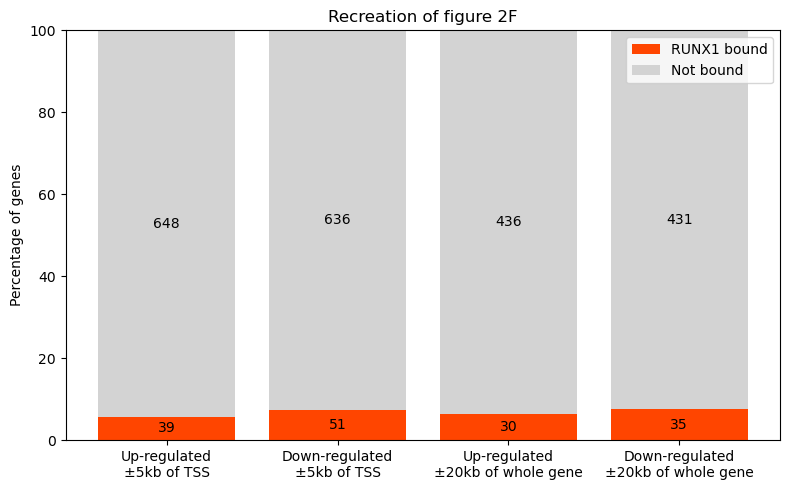

In [9]:
# Find significant differentially expressed genes
deg_up   = rna_seq_df[(rna_seq_df['log2FoldChange'] > 1) & (rna_seq_df['padj'] < 0.01)].copy()
deg_down = rna_seq_df[(rna_seq_df['log2FoldChange'] < -1) & (rna_seq_df['padj'] < 0.01)].copy()

# Check if each peak exists in TSS ±5kb
peak_df['within_5kb_TSS'] = peak_df['Distance to TSS'].abs() <= 5000

# Merge DEG data with peak data
peak_df = peak_df.rename(columns={"Gene Name": "genename"})
up_merged   = pd.merge(deg_up, peak_df, on='genename', how='left')
down_merged = pd.merge(deg_down, peak_df, on='genename', how='left')

def count_bound_genes(df, region="tss"):
    total_genes = df['genename'].nunique()
    if region == "tss":
        bound = df[df['within_5kb_TSS'] == True]['genename'].nunique()
    elif region == "gene":
        bound = df[df['Distance to TSS'].abs() <= 20000]['genename'].nunique()
    else:
        bound = 0
    return bound, total_genes - bound

plot_data = []

for label, data in zip(["Up", "Down"], [up_merged, down_merged]):
    tss_bound, tss_unbound = count_bound_genes(data, region="tss")
    plot_data.append({'Condition': f"{label}-TSS", 'Bound': tss_bound, 'Not Bound': tss_unbound})

    gene_bound, gene_unbound = count_bound_genes(data, region="gene")
    plot_data.append({'Condition': f"{label}-Gene", 'Bound': gene_bound, 'Not Bound': gene_unbound})

# Data preparation for plotting
plot_df = pd.DataFrame(plot_data)
plot_df['Total'] = plot_df['Bound'] + plot_df['Not Bound']
plot_df['% Bound'] = plot_df['Bound'] / plot_df['Total'] * 100
plot_df['% Not Bound'] = plot_df['Not Bound'] / plot_df['Total'] * 100

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))

# RUNX1 bound
ax.bar(plot_df['Condition'], plot_df['% Bound'], color='orangered', label='RUNX1 bound')

# Not bound
ax.bar(plot_df['Condition'], plot_df['% Not Bound'], bottom=plot_df['% Bound'], color='lightgray', label='Not bound')

# Centering labels
for i, row in plot_df.iterrows():
    ax.text(i, row['% Bound']/2, f"{row['Bound']}", ha='center', va='center', color='black', fontsize=10)
    ax.text(i, row['% Bound'] + row['% Not Bound']/2, f"{row['Not Bound']}", ha='center', va='center', color='black', fontsize=10)

ax.set_ylabel('Percentage of genes')
ax.set_ylim(0, 100)
ax.set_xticklabels(['Up-regulated\n±5kb of TSS', 'Down-regulated\n±5kb of TSS',
                    'Up-regulated\n±20kb of whole gene', 'Down-regulated\n±20kb of whole gene'])
ax.set_title('Recreation of figure 2F')
ax.legend()

plt.tight_layout()
plt.show()

**Do you observe any differences in the number of overlapping genes from both analyses?**  

Yes, there was a noticeable difference. In the original paper, the number of RUNX1-bound genes within ±20 kb of the whole gene exceeded 100 for both up-regulated and down-regulated groups, accounting for over 20% of the genes. In contrast, my figure shows only around 30 RUNX1-bound genes in each group, representing less than 10%.

**If you do observe a difference, explain at least two factors that may have contributed to these differences.**  

One contributing factor is the difference in how RUNX1-bound regions were defined. In my analysis, peaks were considered "bound" if located within ±20 kb of the transcription start site (TSS), whereas the original study used ±20 kb of the entire gene body, which is a broader and more inclusive definition. This likely led to an underestimation of bound genes in my results.
A second factor is the reference genome version. The original study used the hg19 genome, while my analysis was based on GRCh38. Differences in gene annotation and genomic coordinates between versions may have caused mismatches during the gene-peak association step, reducing the number of correctly assigned RUNX1-bound genes.

**What is the rationale behind combining these two analyses in this way? What additional conclusions is it supposed to enable you to draw?**  

The rationale for combining ChIP-seq and RNA-seq analyses is to identify genes that are both physically bound by the transcription factor RUNX1 and transcriptionally regulated by it.
By intersecting RUNX1 binding sites with differentially expressed genes upon RUNX1 knockdown, we can distinguish likely direct targets from genes that are regulated indirectly or through downstream pathways.
This integrative approach allows us to draw stronger conclusions about which genes RUNX1 directly controls, rather than relying on expression changes or binding data alone.

### Re-create figure 2D

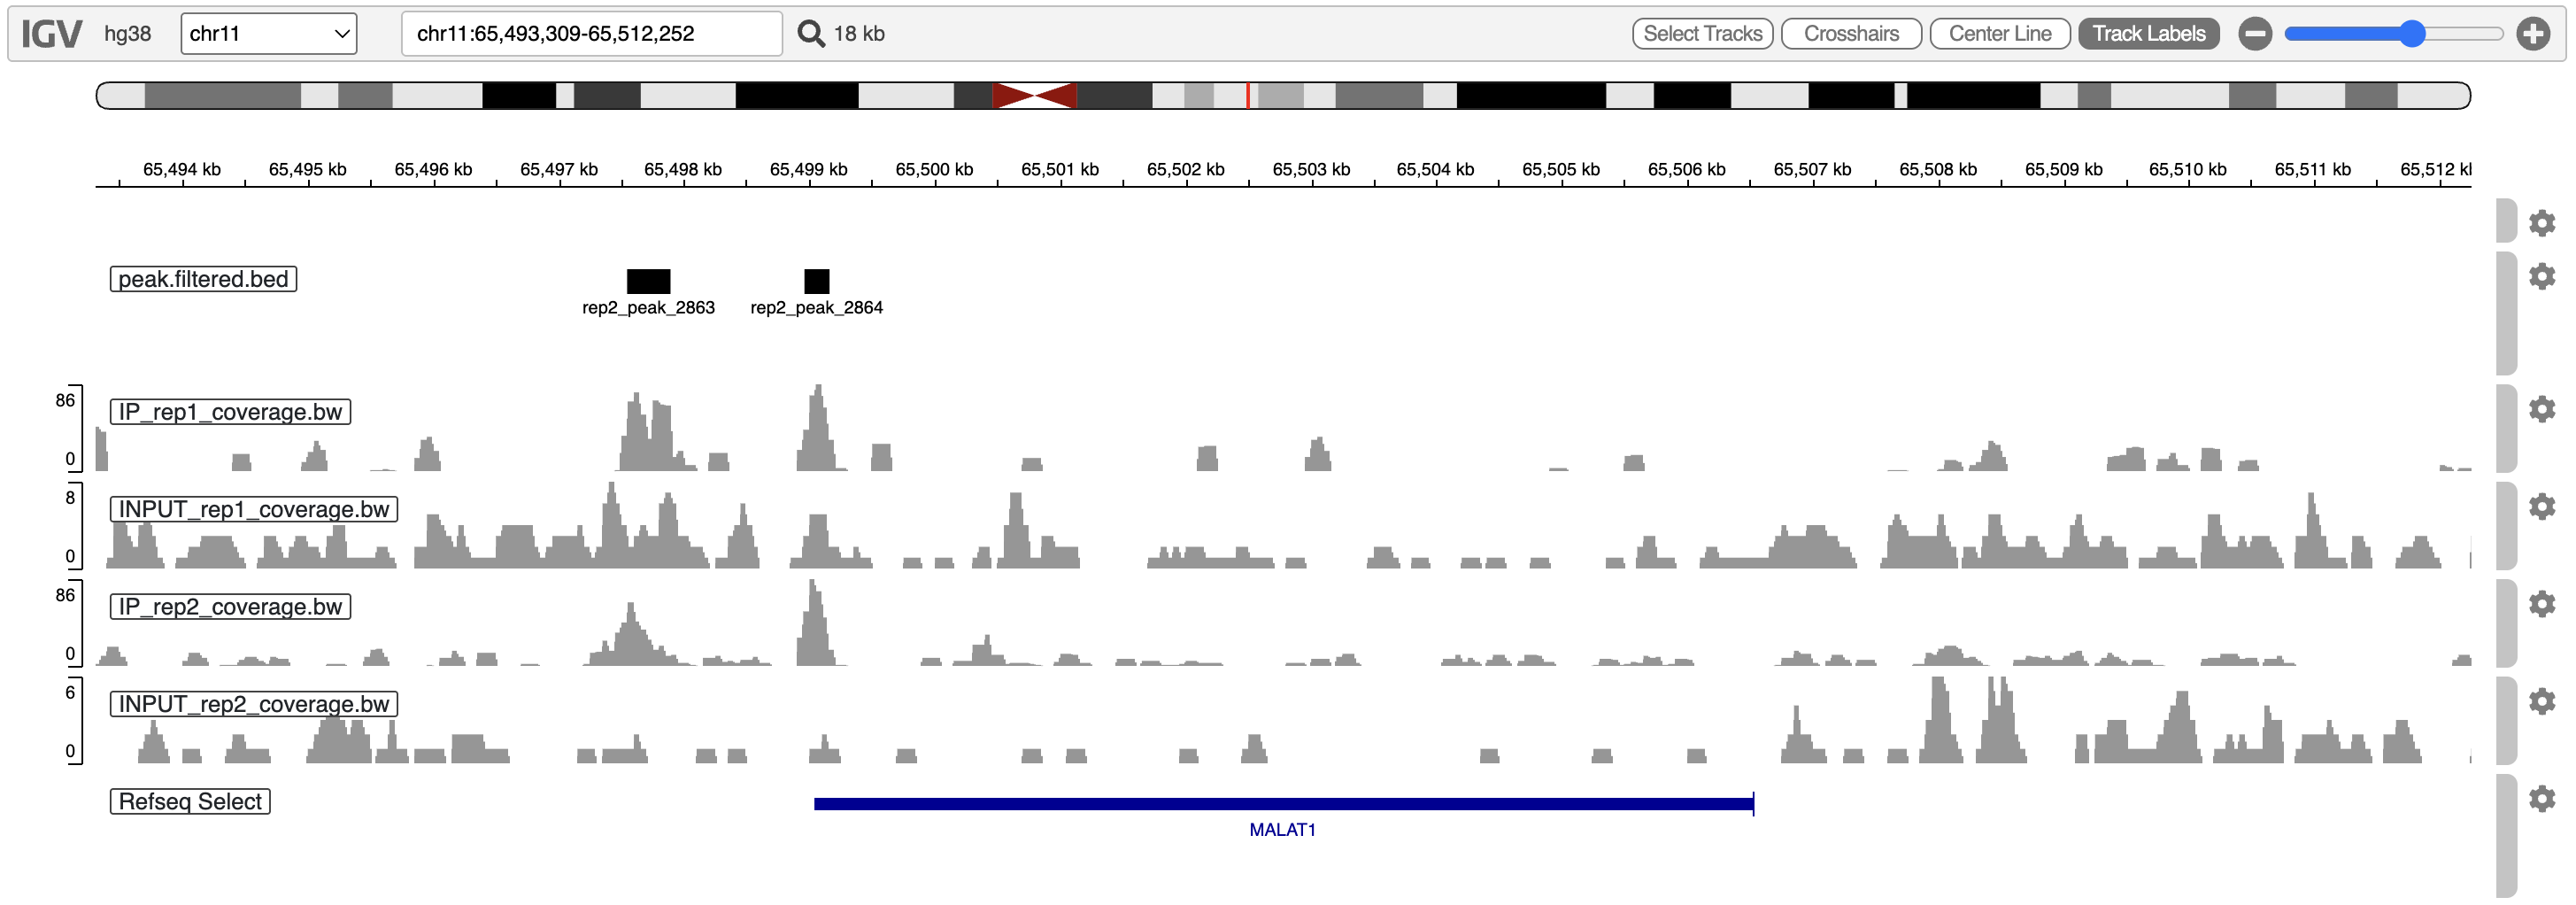
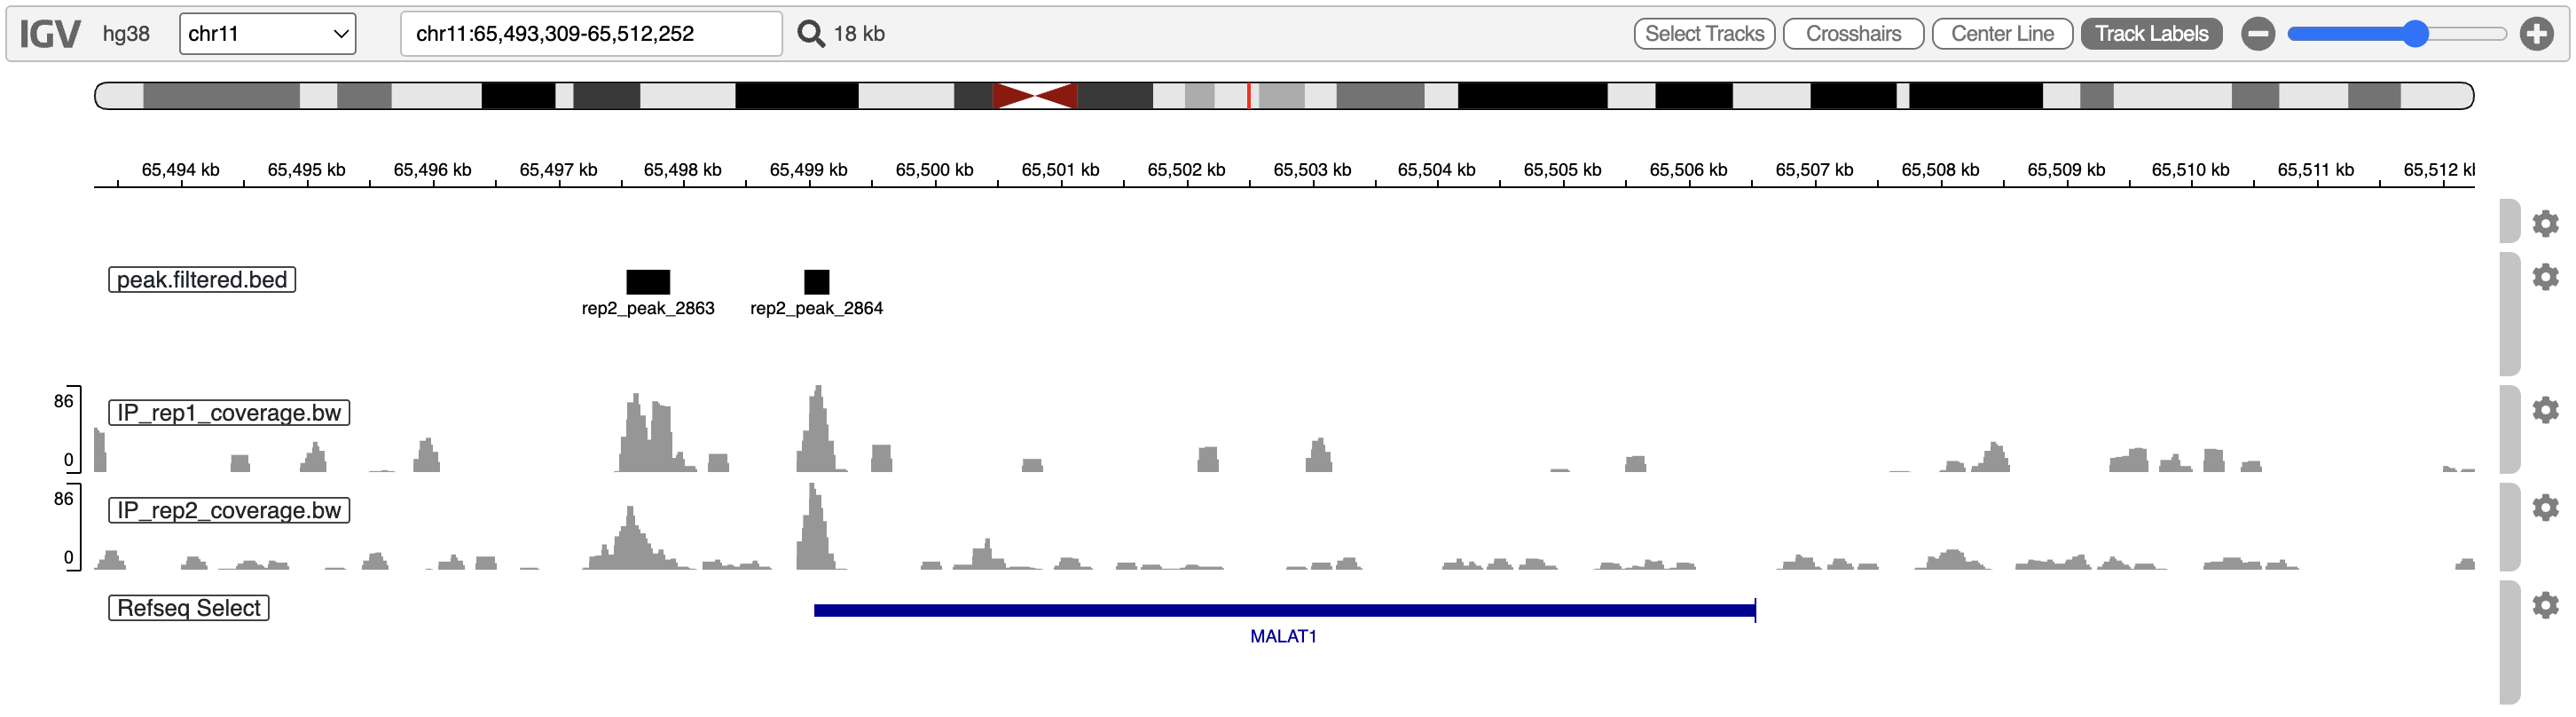
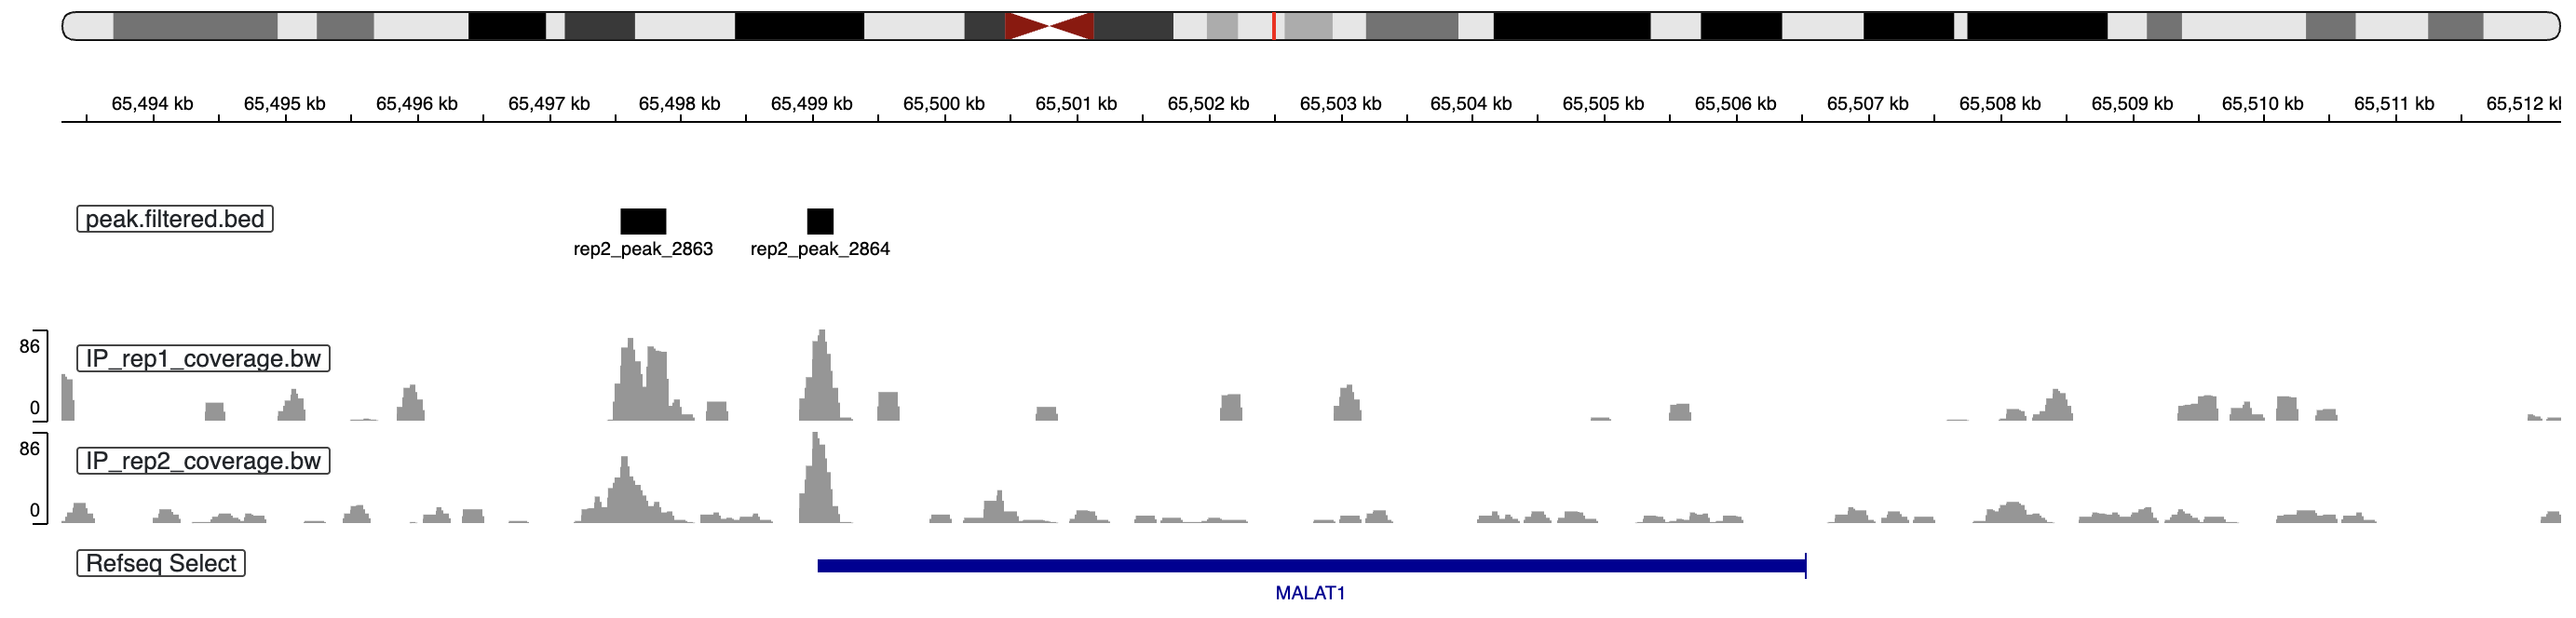

### Re-create figure 2E

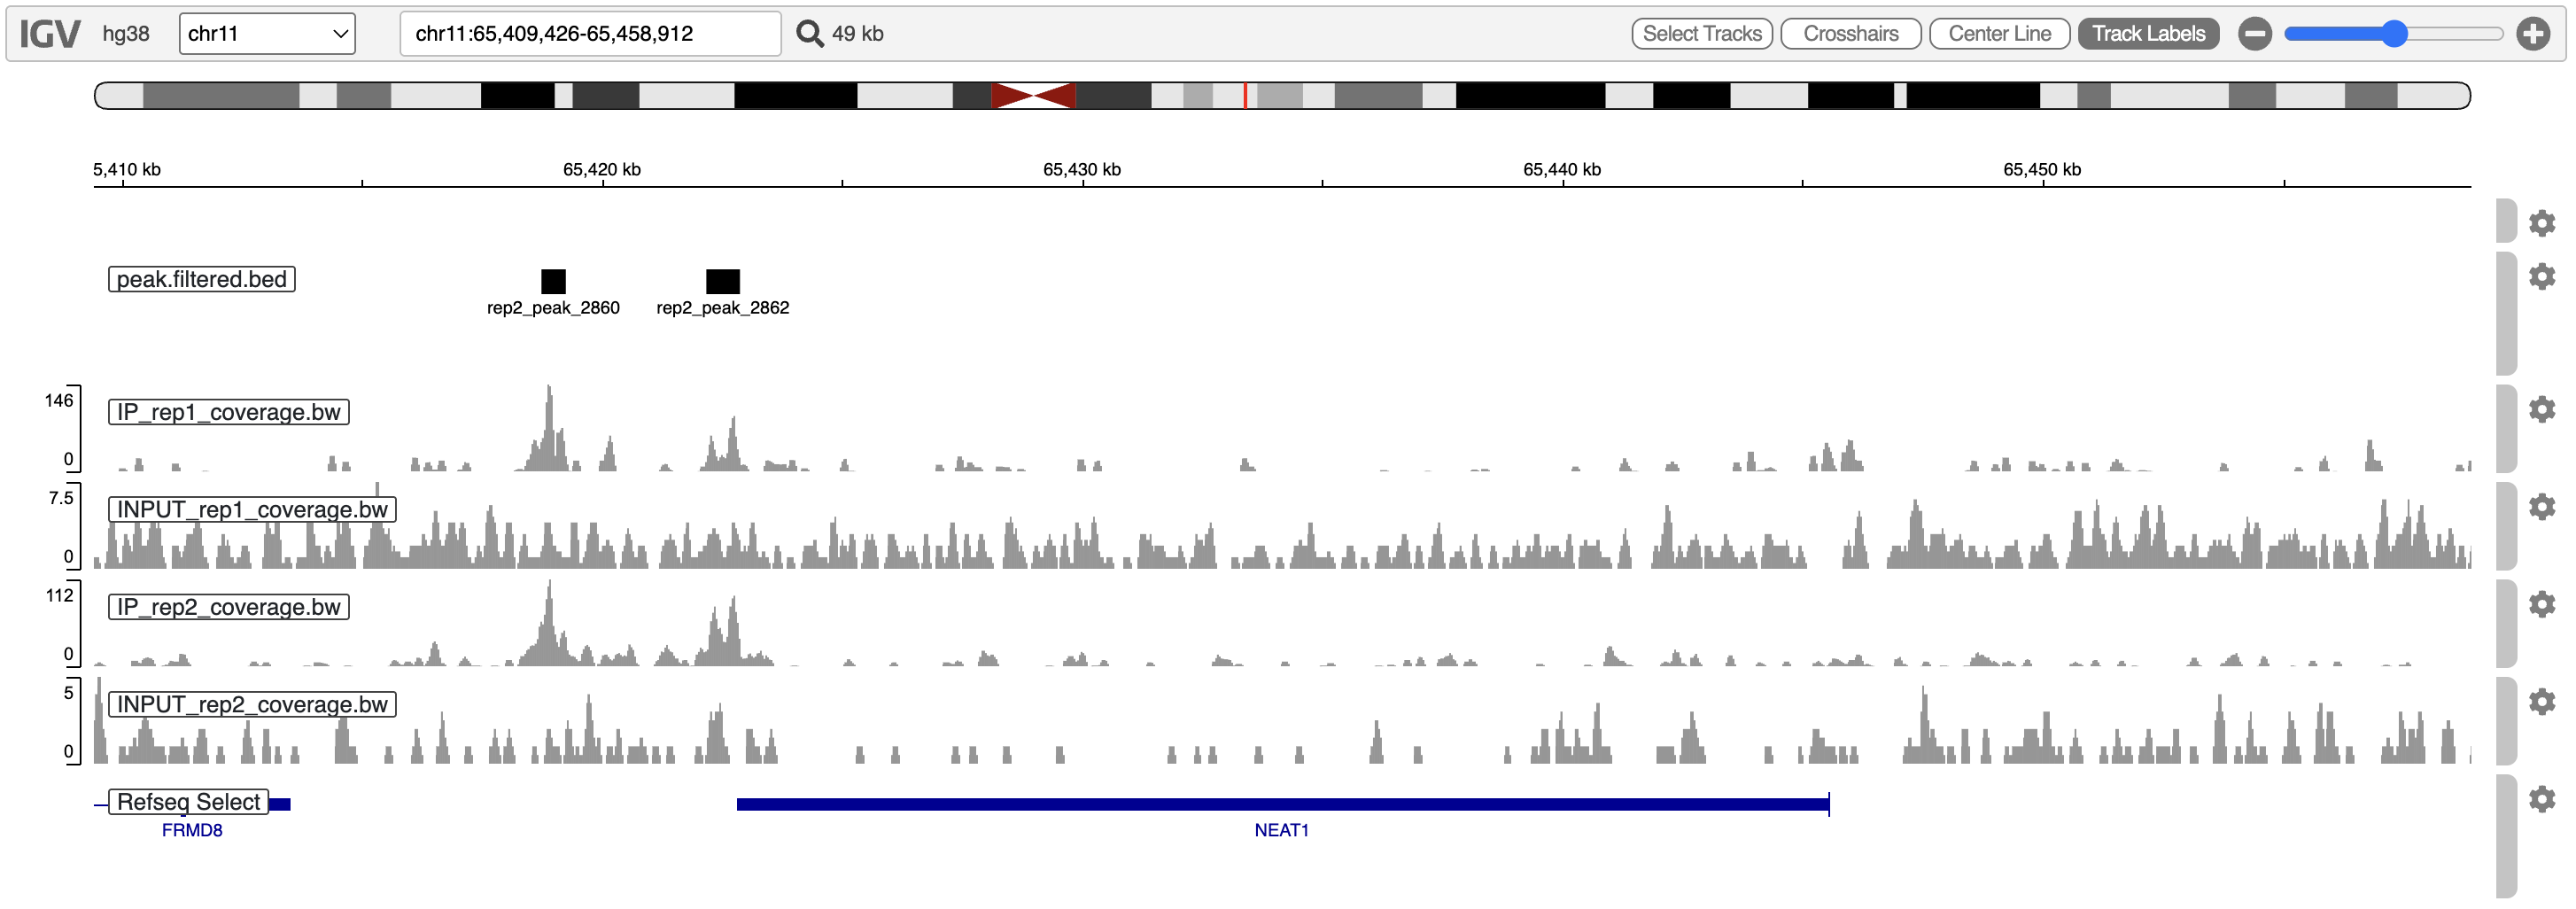
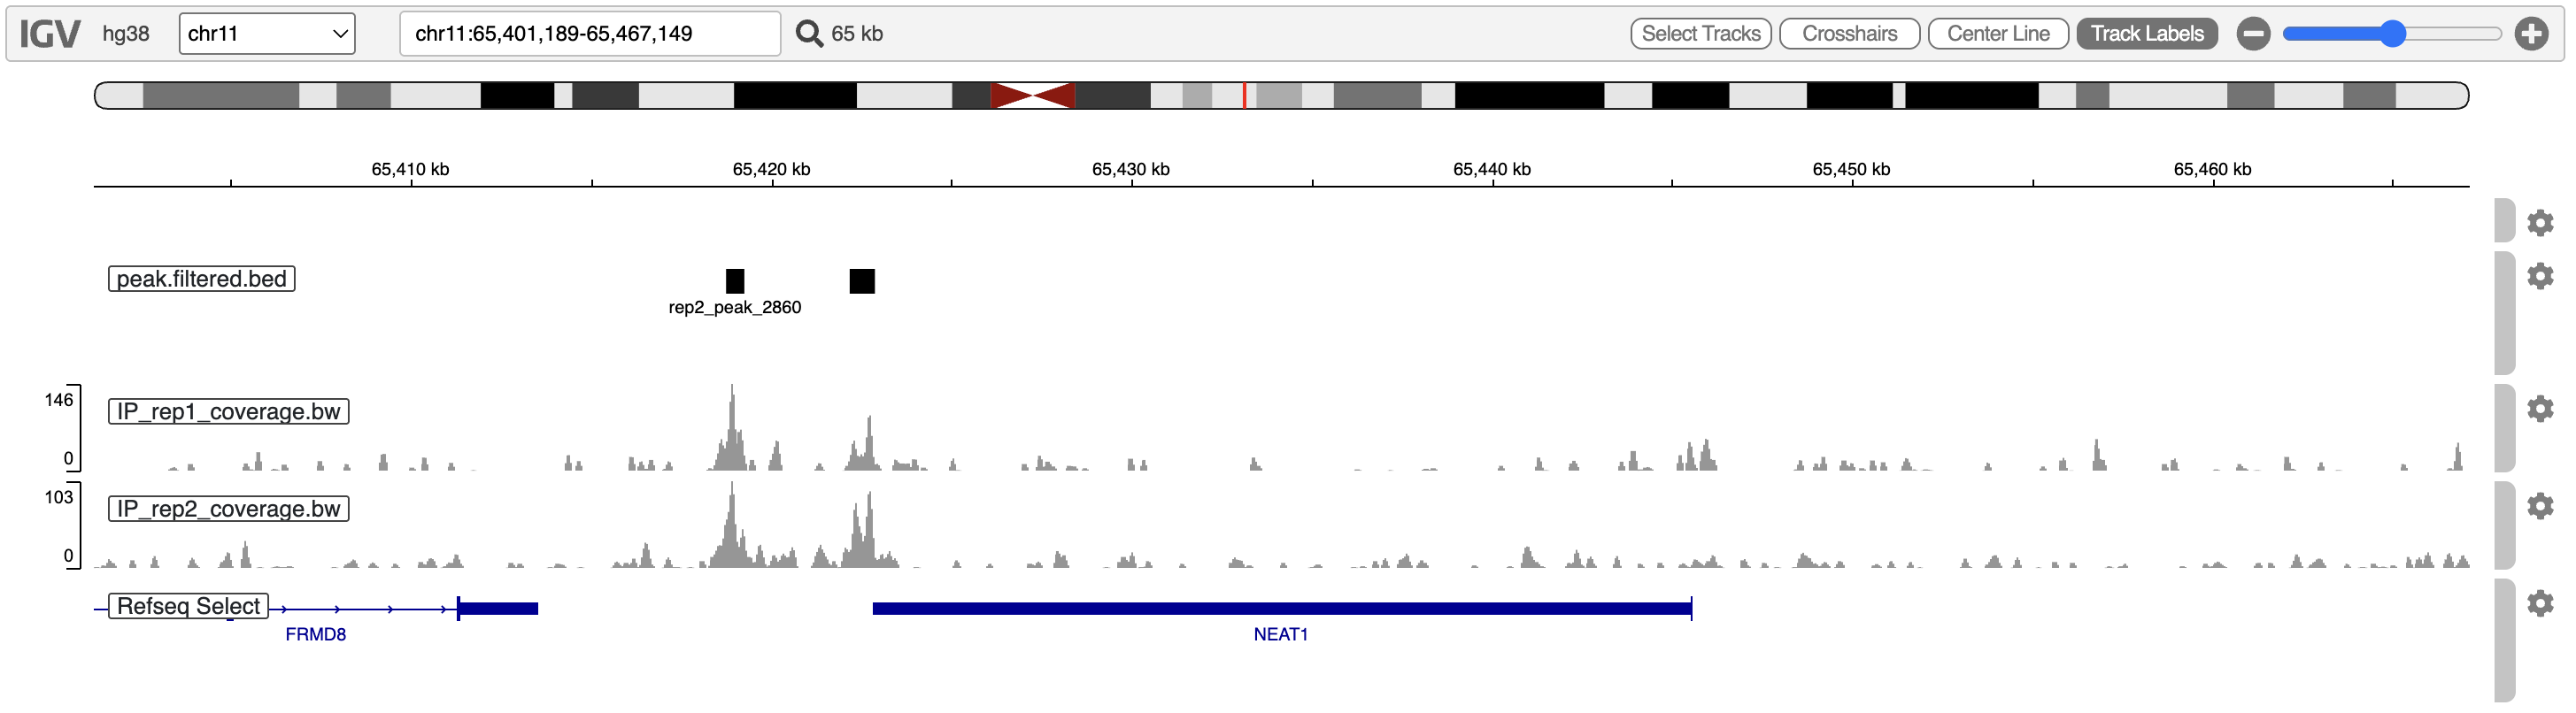
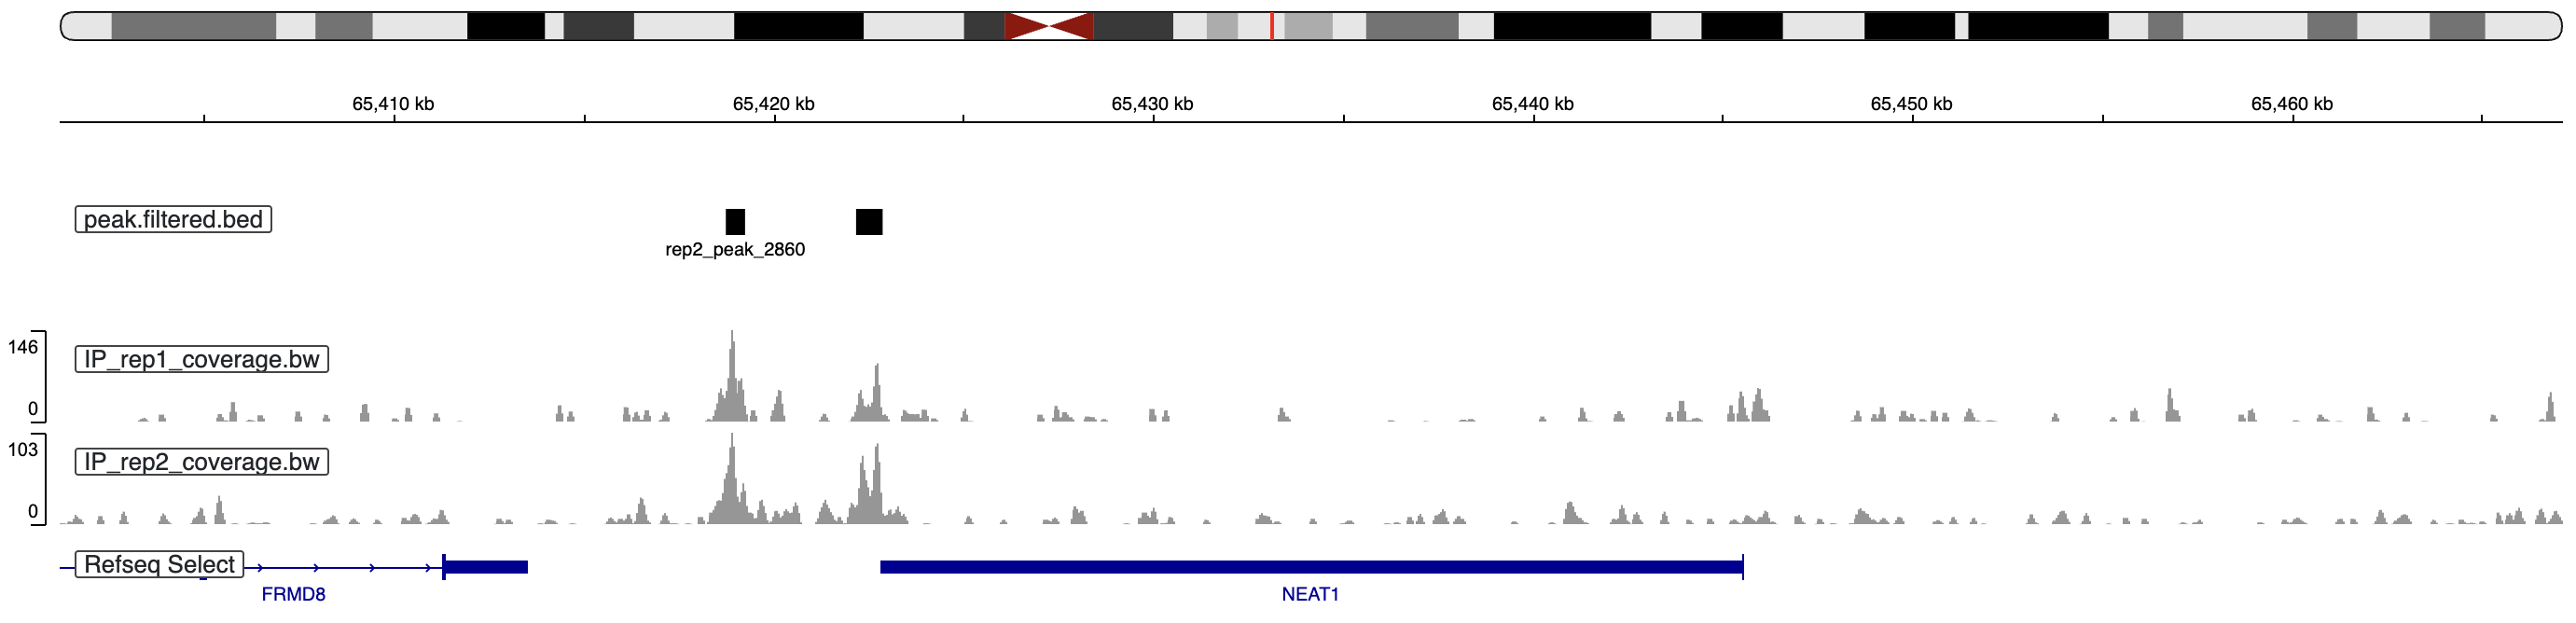

The peaks are located just upstream of the TSS of MALAT1 and NEAT1, which strongly suggests that RUNX1 directly regulates the transcription of these genes. The reproducible signal and the lack of signal in the input tracks further support the specificity of binding. The genomic tracks appear similar to those in the paper.

## Comparing key findings to the original paper

### Re-create figure S2A

In [5]:
data_s2a = {
    "Sample Name": ["RUNX1 ChIP 1", "RUNX1 ChIP 2", "INPUT 1", "INPUT 2"],
    "Biological Replicate": [1, 2, 1, 2],
    "Raw Reads": ["29,404,318", "29,690,027", "29,788,151", "10,763,826"],
    "Mapped Reads": ["27,619,672", "28,035,074", "27,792,626", "9,829,431"]
}

df_s2a = pd.DataFrame(data_s2a)
df_s2a

,Sample Name,Biological Replicate,Raw Reads,Mapped Reads
0,RUNX1 ChIP 1,1,"29,404,318","27,619,672"
1,RUNX1 ChIP 2,2,"29,690,027","28,035,074"
2,INPUT 1,1,"29,788,151","27,792,626"
3,INPUT 2,2,"10,763,826","9,829,431"


**Do you observe differences in the reported number of raw and mapped reads?**  

Yes. While the number of raw reads is similar to the values reported in the paper, the number of mapped reads in my data is noticeably higher.

**If so, provide at least two explanations for the discrepancies.**  

One possible reason is that I used a relatively lenient trimming strategy in Trimmomatic (LEADING:3 and TRAILING:3), which may have preserved more reads for alignment. Additionally, I used the --very-fast mode in Bowtie2, which prioritizes speed over alignment stringency and can result in more reads being mapped.


### Re-create figure S2B

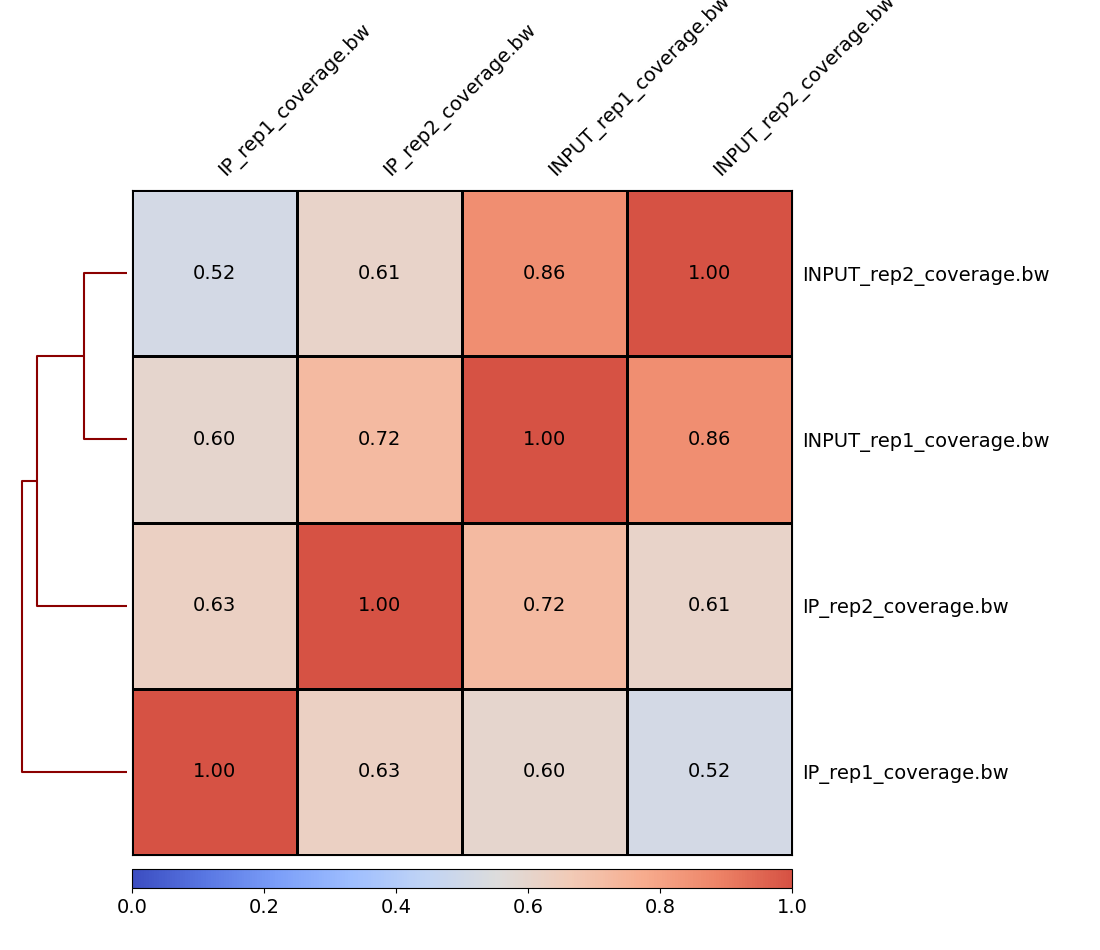

**Do you observe any differences in your calculated metrics?**  

The correlation between the INPUT replicates was high (r = 0.86), while the correlation between the IP replicates was relatively low (r = 0.63).

**What was the author’s takeaway from this figure? What is your conclusion from this figure regarding the success of the experiment?**  

In the paper, the heatmap demonstrates high reproducibility between RUNX1 ChIP replicates (r = 0.91), and shows that RUNX1 ChIP samples clearly cluster separately from INPUT samples.
This figure suggests that the experiment was successful. The high correlation between the RUNX1 ChIP replicates indicates good reproducibility, and the lower correlation with INPUT samples confirms that the ChIP signal is distinct from background.
The clustering of replicates and separation between IP and INPUT groups further supports the quality and specificity of the RUNX1 ChIP-seq data.

### Re-create figure S2C

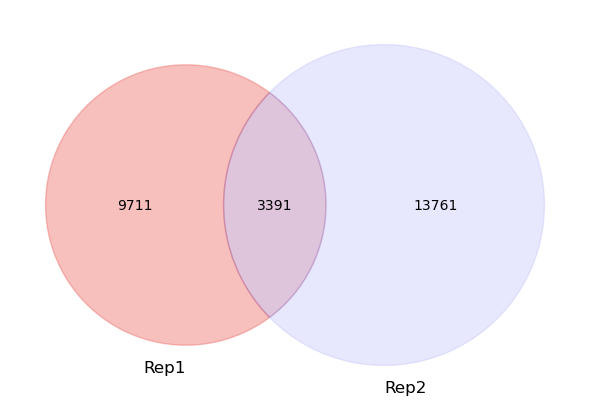

In [11]:
def count_lines(filepath):
    with open(filepath) as f:
        return sum(1 for _ in f)

# Count peaks in each file
rep1_total = count_lines("./results/callpeak_rep1/rep1_peaks.narrowPeak")
rep2_total = count_lines("./results/callpeak_rep2/rep2_peaks.narrowPeak")
common = count_lines("./results/reproducible_peaks.bed")

# Calculate unique peaks
rep1_only = rep1_total - common
rep2_only = rep2_total - common

# Venn diagram
plt.figure(figsize=(6,5))
v = venn2(subsets=(rep1_only, rep2_only, common), set_labels=("Rep1", "Rep2"))

# Set colors for the circles and intersection
v.get_patch_by_id('10').set_color('#EC625C')  # Rep1
v.get_patch_by_id('01').set_color('#C4C4FA')  # Rep2
v.get_patch_by_id('11').set_color('#AD6EA8')  # common

plt.tight_layout()
plt.show()

**Do you observe any differences in your results compared to what you see?**  

Although the number of shared peaks between Rep1 and Rep2 is similar to the original study, the number of Rep1-only peaks is substantially higher in my analysis (9,711 vs. 3,983 in the paper).

**If so, provide at least two explanations for the discrepancies in the number of called peaks.**  

This discrepancy may result from differences in peak calling thresholds, filtering steps such as blacklist removal, or replicate variability. In particular, lower correlation in Rep1 (r = 0.63, shown in the heatmap above) suggests reduced reproducibility, possibly contributing to a higher number of Rep1-specific peaks, many of which may represent noise or low-confidence regions.

## Analyze the annotated peaks

**In your created notebook, detail the methodology used to perform the enrichment.**  

Peaks annotated as “promoter-TSS” were selectively extracted from the HOMER-generated annotation file, as promoter regions near transcription start sites (TSS) are most likely to be involved in transcriptional regulation. From these promoter-associated peaks, the corresponding gene symbols (listed under the “Gene Name” column) were collected and deduplicated to generate a list of unique genes. This gene list was then submitted to Enrichr.

Create gene list for Enrichr

In [ ]:
# Read peak annotation file
peak_df = pd.read_csv("./results/peak_annotation.txt", sep="\t", comment='#')

# Extract promoter-TSS
promoter_df = peak_df[peak_df["Annotation"].str.contains("promoter-TSS", na=False)]

# Extract gene names
gene_list = promoter_df["Gene Name"].dropna().unique()

# Save gene names to a text file
with open("gene_list.txt", "w") as f:
    for gene in gene_list:
        f.write(gene + "\n")

**Create a single figure / plot / table that displays some of the top results from the analysis.**

### Reactome Pathways 2024
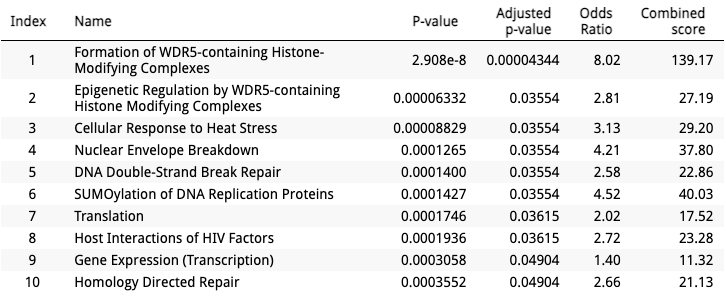

**Comment briefly in a paragraph about the results you observe and why they may be interesting.**  

The enrichment results reveal that RUNX1-bound regions are highly associated with pathways involved in epigenetic regulation and genome maintenance, particularly the formation of WDR5-containing histone-modifying complexes and DNA repair processes. Given RUNX1's known role as a transcription factor in hematopoiesis and leukemia, its association with these pathways suggests that it may coordinate chromatin remodeling and genomic stability, potentially regulating key gene networks involved in cell differentiation, stress response, and DNA damage repair. These findings align with RUNX1’s established function in controlling transcriptional programs critical for hematopoietic lineage commitment and genomic integrity.